In [47]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os  
import random  
import torch
import torch.nn as nn
import math
import imutils
from PIL import Image
import torchvision.transforms as transforms
import csv
import pandas as pd
import ast
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [48]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

In [50]:
class Transforms():
    """
    Transforms for the training, validation, and testing sets
    We only use the resize transform
    """
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, angle)
        center = (image.size[1] / 2, image.size[0] / 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(np.array(image), M, (image.size[1], image.size[0]))
        A = M[:,:2]
        B = M[:,2]
        new_landmarks = []
        for landmark in landmarks:
            new_landmark = np.dot(A,landmark.T) + B
            # new_landmarks = np.row_stack((new_landmarks, new_landmark))
            new_landmarks = np.append(new_landmarks,new_landmark)
            new_landmarks = np.array(new_landmarks)
        return Image.fromarray(image), new_landmarks
    
    def resize(self, image, landmarks, img_size):
        w1, h1 = image.size
        w2, h2 = img_size
        landmarks = landmarks * np.array([w2/w1, h2/h1])
        image = image.resize(img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks
    
    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        # image, landmarks = self.color_jitter(image, landmarks)
        # image, landmarks = self.rotate(image, landmarks, angle=10)
        transf = transforms.ToTensor()
        image_tensor = transf(image)
        return image_tensor, landmarks

In [52]:
class ButterflyLandmarksDataset(torch.utils.data.Dataset):
    """
    Dataset class for the training, validation, and testing sets
    """
    def __init__(self, imagefolder, transform = None):
        self.transform = transform
        self.image_filenames = []
        self.landmarks = []
        self.root_dir = 'C:\\Users\\14552\\Desktop\\project\\Heliconius_forewing_band-master\\dataset_wash' + '\\' + imagefolder
        csv_file = pd.read_csv(self.root_dir +  "\\" + imagefolder + '.csv')
        self.image_filenames = csv_file['image_name'].values
        self.landmarks = csv_file['landmarks'].values
        self.landmarks = [ast.literal_eval(landmark) for landmark in self.landmarks]
        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.root_dir, self.image_filenames[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        landmark = self.landmarks[index]
        if self.transform:
            image, landmark = self.transform(image, landmark)
        return image, landmark



In [1]:
# val_set = ButterflyLandmarksDataset('val', transform=Transforms(), align=False)

# for i in range(len(val_set)):
#     image, landmarks = val_set[i]
#     input_labels = np.array([1]*18,dtype='int')
#     # print(landmarks.shape)
#     landmarks = landmarks.reshape(18,2)
#     # print(landmarks.shape)
#     plt.imshow(image.permute(1, 2, 0))
#     show_points(np.array(landmarks), input_labels, plt.gca())
#     plt.axis('on')
#     plt.show()  


In [53]:
train_dataset = ButterflyLandmarksDataset('train', transform=Transforms())
val_dataset = ButterflyLandmarksDataset('val', transform=Transforms())

print("The length of Train set is {}".format(len(train_dataset)))
print("The length of Validation set is {}".format(len(val_dataset)))
# print("The length of Test set is {}".format(len(test_dataset)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)


The length of Train set is 174
The length of Validation set is 25


In [54]:
print(train_dataset[0][1].shape)

(18, 2)


In [55]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 18, 2])


In [56]:
class Network(nn.Module):
    """
    The network architecture, no skip connections
    """
    def __init__(self, num_classes=18*2):
        super(Network, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # nn.PReLU(),
            nn.MaxPool2d(2, 2), # 112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.PReLU(),
            nn.MaxPool2d(2, 2), # 56

            nn.Conv2d(64, 128, 3, padding=1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.PReLU(),
            nn.MaxPool2d(2, 2) # 28
            )
        self.fc = nn.Linear(28*28*128, num_classes)
         
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)
        return x
    

class skip_Network(nn.Module):
    """
    The network architecture, with skip connections
    """
    def __init__(self, num_coors=18*2):
        super(skip_Network, self).__init__()
        self.cnn_layers_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # nn.PReLU(),
            nn.MaxPool2d(2, 2), # 112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.PReLU(),
            nn.MaxPool2d(2, 2), # 56
        )
        self.cnn_layers_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.PReLU(),
            nn.MaxPool2d(2, 2) # 28
        )
        self.fc = nn.Linear(56*56*64+28*28*128, num_coors)
    
    def forward(self, x):
        x1 = self.cnn_layers_1(x)
        x2 = self.cnn_layers_2(x1)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x


In [58]:
from torchvision import models
class Network_1(nn.Module):
    """
    The network architecture using resnet18
    """
    def __init__(self,num_classes=18*2):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x
    
class Network_2(nn.Module):
    """
    The network architecture using efficientnet_b0
    """
    def __init__(self,num_classes=18*2):
        super().__init__()
        self.model_name='efficientnet_b0'
        self.model=models.efficientnet_b0()
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        self.model.classifier=nn.Sequential(
            nn.Dropout(0.2, inplace=True),
            nn.Linear(1280, num_classes),
        )

    def forward(self, x):
        x=self.model(x)
        return x

# print(models.efficientnet_b0().classifier)
from torchvision import models
class Network_3(nn.Module):
    """
    The network architecture using resnet34
    """
    def __init__(self,num_classes=18*2):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34()
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [2]:
# from torchview import draw_graph
# model_1 = skip_Network(18*2)
# batch_size = 32
# # device='meta' -> no memory is consumed for visualization
# model_graph = draw_graph(model_1, input_size=(batch_size, 3,224,224), device='meta')
# model_graph.visual_graph

In [59]:
# train the model
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
model = skip_Network(18*2)
model.cuda()
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def adjust_lr(optimizer, train_loss):
    if train_loss <= 50:
        lr = 1e-4
    elif train_loss <= 40:
        lr = 1e-5
    elif train_loss <= 30:
        lr = 1e-6
    elif train_loss <= 20:
        lr = 1e-7
    else:
        lr = 1e-3
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_epochs = 50
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for _, data in enumerate(train_loader):
        images, landmarks = data
        images = images.cuda()
        landmarks = landmarks.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        # resize the output to match the size of the target
        landmarks = landmarks.type(torch.cuda.FloatTensor)
        landmarks = landmarks.reshape(landmarks.shape[0], -1)
        loss = criterion(outputs, landmarks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    # update the learning rate
    adjust_lr(optimizer, train_loss)
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, landmarks = data
            images = images.cuda()
            landmarks = landmarks.cuda()
            landmarks = landmarks.type(torch.cuda.FloatTensor)
            outputs = model(images)
            outputs = outputs.reshape(landmarks.shape)
            loss = criterion(outputs, landmarks)
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        val_loss_list.append(val_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), 'model_effnetb0_{}.pth'.format(epoch+1))

skip_Network(
  (cnn_layers_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layers_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

KeyboardInterrupt: 

In [60]:
def plot_histories(train_history=None, val_history=None, label="Loss"):
    """
    Takes a list of training and/or validation metrics and plots them
    Returns: plt.figure and ax objects
    """
    if not train_history and not val_history:
        raise ValueError("Must specify at least one of 'train_histories' and 'val_histories'")
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    
    epochs = np.arange(len(train_history or val_history))
    if train_history:
        ax.plot(epochs, train_history, label="Training", color="black")
    if val_history:
        ax.plot(epochs, val_history, label="Validation", color="darkred")
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend(loc=0)

    
    return fig, ax


(<Figure size 500x300 with 1 Axes>, <Axes: xlabel='Epoch', ylabel='Loss'>)

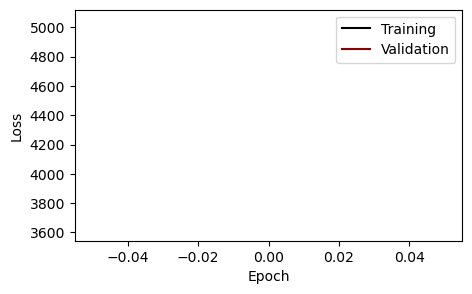

In [61]:
plot_histories(train_history=train_loss_list, val_history=val_loss_list, label="Loss")

In [62]:
# predict the landmarks and get the loss
criterion = nn.MSELoss()
model = skip_Network(18*2)
model.load_state_dict(torch.load("model_skip_connection_50.pth"))
model.cuda()
test_dataset = ButterflyLandmarksDataset('test', transform=Transforms())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, landmarks = data
        images = images.cuda()
        landmarks = landmarks.cuda()
        landmarks = landmarks.type(torch.cuda.FloatTensor)
        outputs = model(images)
        outputs = outputs.reshape(landmarks.shape)
        loss = criterion(outputs, landmarks)
        test_loss += loss.item()
    test_loss = test_loss / len(test_loader)
print(test_loss)


10.143864631652832


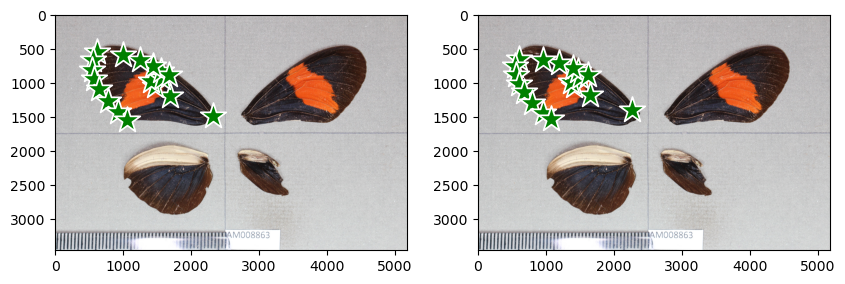

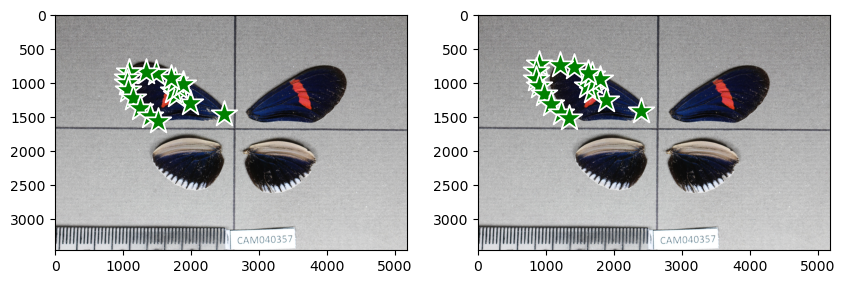

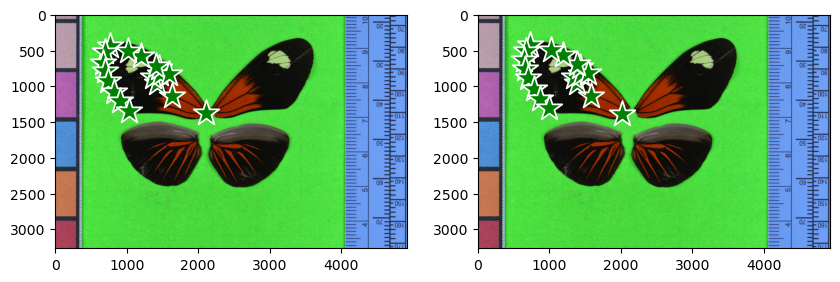

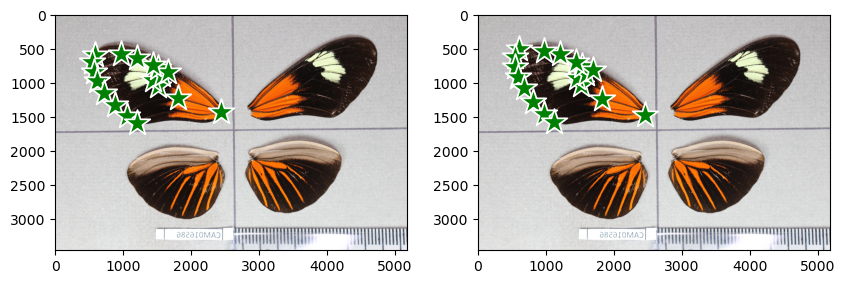

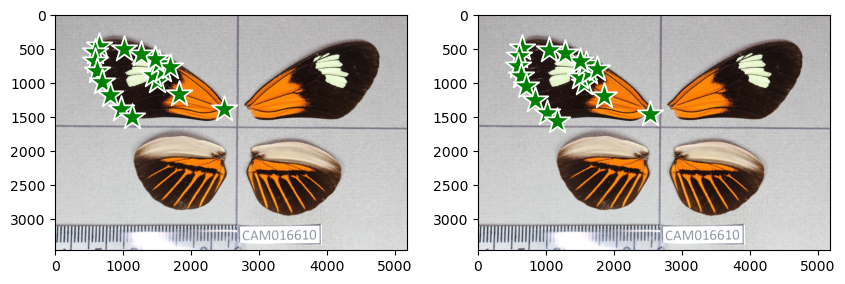

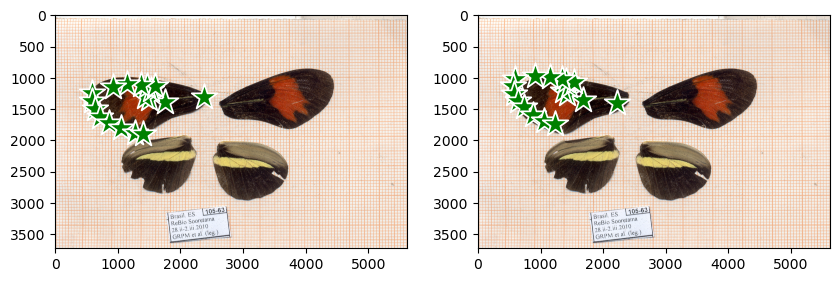

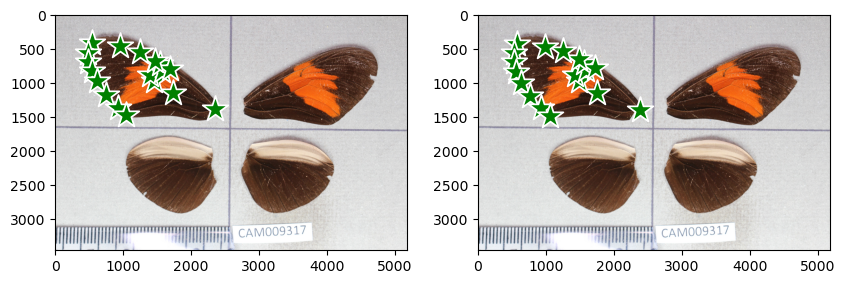

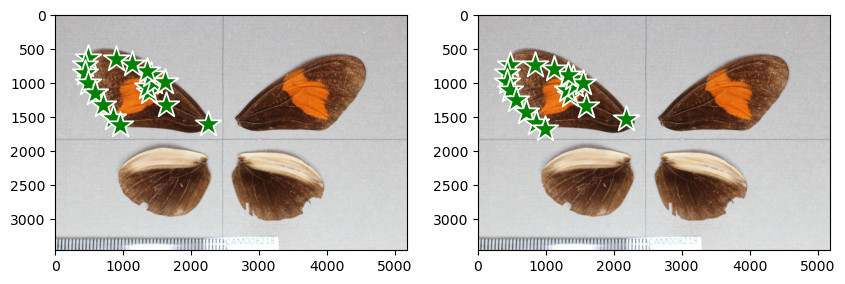

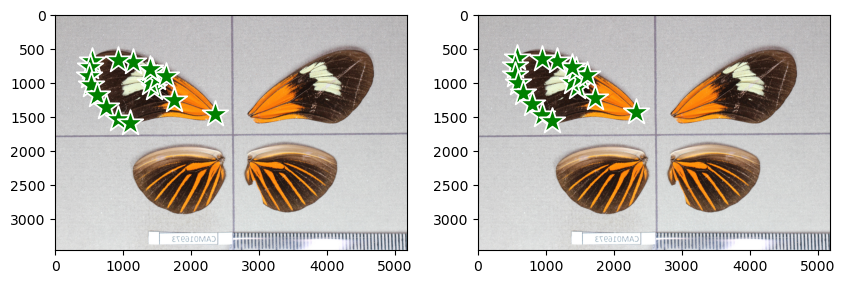

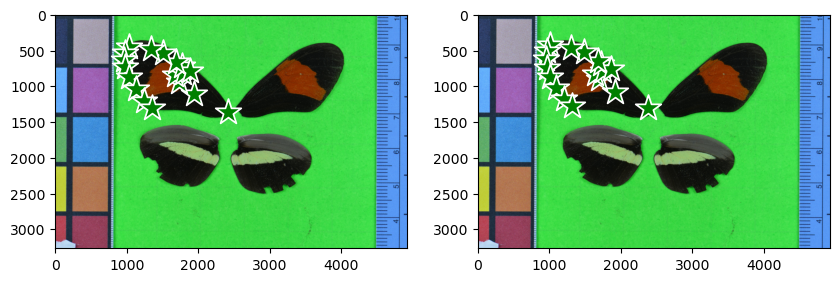

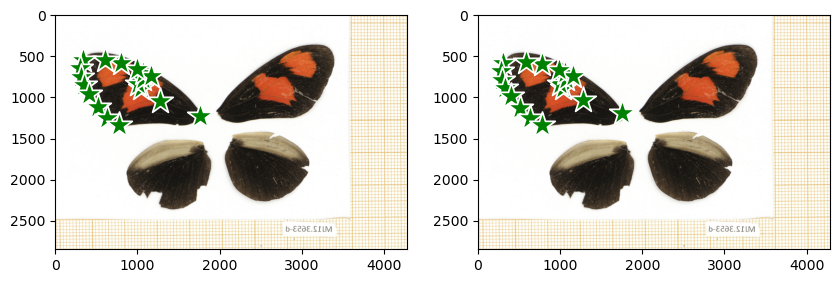

KeyboardInterrupt: 

In [63]:
# predict the landmarks and visualize the results

test_set = ButterflyLandmarksDataset('test', transform=None)

for i in range(len(test_set)):
    image, landmarks_ori = test_set[i]
    w1, h1 = image.shape[1], image.shape[0]
    w2, h2 = 224, 224
    input_labels = np.array([1]*18,dtype='int')
    landmarks_ori = landmarks_ori.reshape(18,2)
    image = PIL.Image.fromarray(image)
    image = image.resize((224, 224))
    landmarks = landmarks_ori * np.array([w2/w1, h2/h1])
    image = transforms.ToTensor()(image)
    

    image = image.cuda()
    image = image.unsqueeze(0)
    output = model(image)
    output = output.reshape(18,2)
    output = output.cpu().detach().numpy()
    # transform the landmarks back to the original size
    output = output * np.array([w1/w2, h1/h2])
    img_show = PIL.Image.fromarray(test_set[i][0])

    ax, fig = plt.subplots(1, 2, figsize=(10, 10))
    fig[0].imshow(img_show)
    show_points(np.array(landmarks_ori), input_labels, fig[0])
    fig[0].axis('on')
    fig[1].imshow(img_show)
    show_points(np.array(output), input_labels, fig[1])
    fig[1].axis('on')
    plt.show()
 